# Population Inference with Redshifts

This notebook outlines how to derive population redshift distributions from a given collection of **redshift PDFs**. This simple case allows us to introduce most of the critical ideas and extensions that serve as the foundation for **hierarchical inference**, inference over samples, and inference over $p$-D **photometric PDFs**.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

print('Number of observed redshifts:', Nobs)

Number of observed redshifts: 20000


# Population Redshift Density Estimation

For every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, let's assume we have an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We can construct an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z_h|z) = K(z_h|z), \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) \rightarrow P(z_g|z_h) = \frac{P(z_g, z_h)}{P(z_h)} = \frac{\int P(z_g | z) K(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) K(z_h | z) P(z) dz}
$$

where the notation $K(z_h|z)$ is meant to suggest a **kernel density** and differentiate it from $P(z_g|z)$.

## Noiseless Case

In the case where our observations are error-less such that $P(z_g|z) = \delta(z_g - z)$ (where $\delta(\cdot)$ is the Dirac delta function), our prior $P(z) = 1$ is uniform, and our basis is properly normalized such that $\int K(z_h|z) dz = 1$, this just reduces to

$$ P(z_g|z_h) = \frac{K(z_h|z_g)}{\sum_{g \in \mathbf{g}} K(z_h|z_g)} $$

which is just the value of our redshift kernel $K(z_h|z)$ evaluated at $z_g$.

## Top-hat Kernels (Histogram)

One common choice of basis is a series of redshift **bins** (i.e. a histogram), which can be modeled using a **top-hat kernel** consisting of a product of **Heavyside functions**

$$
K(z_h|z) = \frac{\mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z)}{z_h^{+} - z_h^{-}}
$$

where $z_h^{\pm}$ are the bin edges. In the errorless case above this just evaluates to $\frac{1}{z_h^{+} - z_h^{-}}$ if $z_g \in \left[z_h^{-}, z_h^{+}\right)$ and $0$ otherwise.

We can define our projection over this basis using **Bayes Theorem** as

$$
P(h|g) = \frac{P(g|h)P(h)}{P(g)} = \frac{P(g|h)P(h)}{\sum_{h \in \mathbf{h}} P(g|h)P(h)}
$$

Assuming our **prior** $P(h)=1$ is uniform over our redshift bins, the **evidence** (also called the **marginal likelihood**) becomes $P(g) = \sum_{g \in \mathbf{h}} P(g|h) P(h) = (z_h^{+} - z_h^{-})^{-1}$ and 

$$
P(h|g) = \mathcal{H}(z_g - z_h^{-})\mathcal{H}(z_h^{+} - z_g)
$$

Our number density is then defined as

$$ N(h|\mathbf{g}) \equiv \sum_{g \in \mathbf{g}} P(h|g) = \sum_{g \in \mathbf{g}} \mathcal{H}(z_g - z_h^{-})\mathcal{H}(z_h^{+} - z_g) $$

We can turn this into a normalized PDF by defining

$$ P(h|\mathbf{g}) \equiv N(h|\mathbf{g}) / N_\mathbf{g}  $$

This formalism might seem somewhat like an overly complicated way to say "count up the number of galaxies in each redshift bin and normalize then", but it will prove useful shortly once we start generalizing our results.

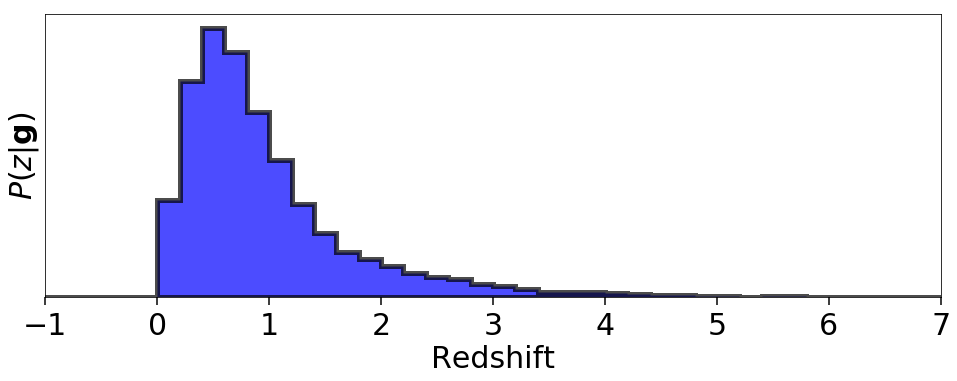

In [4]:
dzbin = 0.2
zbins = np.arange(-1, 7.+1e-5, dzbin)  # redshift bins
zbins_mid = 0.5 * (zbins[1:] + zbins[:-1])  # bin midpoints
Nbins = len(zbins) - 1

# plotting histogrammed representation
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel(r'$P(z|\mathbf{g})$')
plt.tight_layout()

## Gaussian Kernels (Smooth KDE)

Alternately, we can construct a smooth density estimate by using, e.g., a **Gaussian (Normal) kernel** as a basis rather than a tophat kernel. Each kernel will then have mean $\mu_h$ with a smoothing scale of $\sigma_h$ such that 

$$ K(z_h|z) = \mathcal{N}(z|\mu=\mu_h, \sigma^2=\sigma^2_h) 
\equiv \frac{1}{\sqrt{2\pi}\sigma_h} \exp\left[ -\frac{1}{2} \frac{(z - \mu_h)^2}{\sigma_h^2} \right] $$

Our new estimator is then

$$
N(h|\mathbf{g}) = \sum_{g \in \mathbf{g}} \mathcal{N}(z_g|\mu=z_h, \sigma^2=\sigma^2_h) 
$$

This results in a smoother estimator.

Note that due to the nature of the problem, there is a symmetry between assign our kernel density estimates (i.e. "errors") to our redshift basis vs assigning them to our observed redshifts. This allows us to exploit some of the **kernel density estimation (KDE)** functionality of `frankenz` (which is designed to deal with projecting PDFs onto delta functions) to evaluate this.

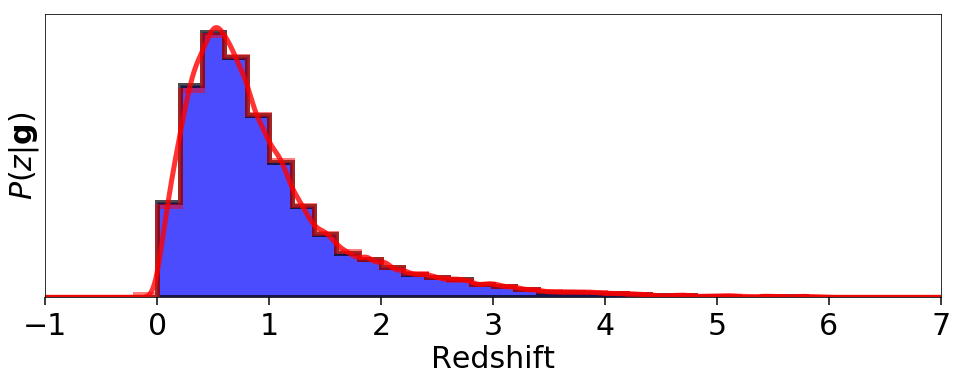

In [5]:
# KDE
dzgrid = 0.01
zgrid = np.arange(-1., 7.+1e-5, dzgrid)
Ngrid, smooth = len(zgrid), 0.05
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * smooth, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

## Noisy Case

Let's say that we're actually dealing with a noisy redshift estimate $\hat{z}_g$. This leaves us with:

$$
P(g|h) \rightarrow P(\hat{z}_g|z_h) = \frac{\int P(\hat{z}_g | z) K(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(\hat{z}_g | z) K(z_h | z) P(z) dz}
$$

Let's assume our errors are Gaussian such that $P(\hat{z}_g|z) = \mathcal{N}(\hat{z}_g|\mu=z, \sigma=\hat{\sigma}_g)$, where we assume the error $\hat{\sigma}_g$ is also estimated but which we will take to be fixed.

In [6]:
# generate Gaussian PDFs over grid
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

In [7]:
# generate PDFs over bins
zpdf_bins = np.array([frankenz.pdf.gaussian_bin(mu[i], sigma[i], zbins) 
                      for i in range(Nobs)])  # redshift pdfs
zpdf_bins /= zpdf_bins.sum(axis=1)[:,None] * dzbin  # normalizing

To avoid edge effects, for our simulated data we will allow for negative redshifts so that producing a "correct" PDF involves simply shifting the mean of the Gaussian.

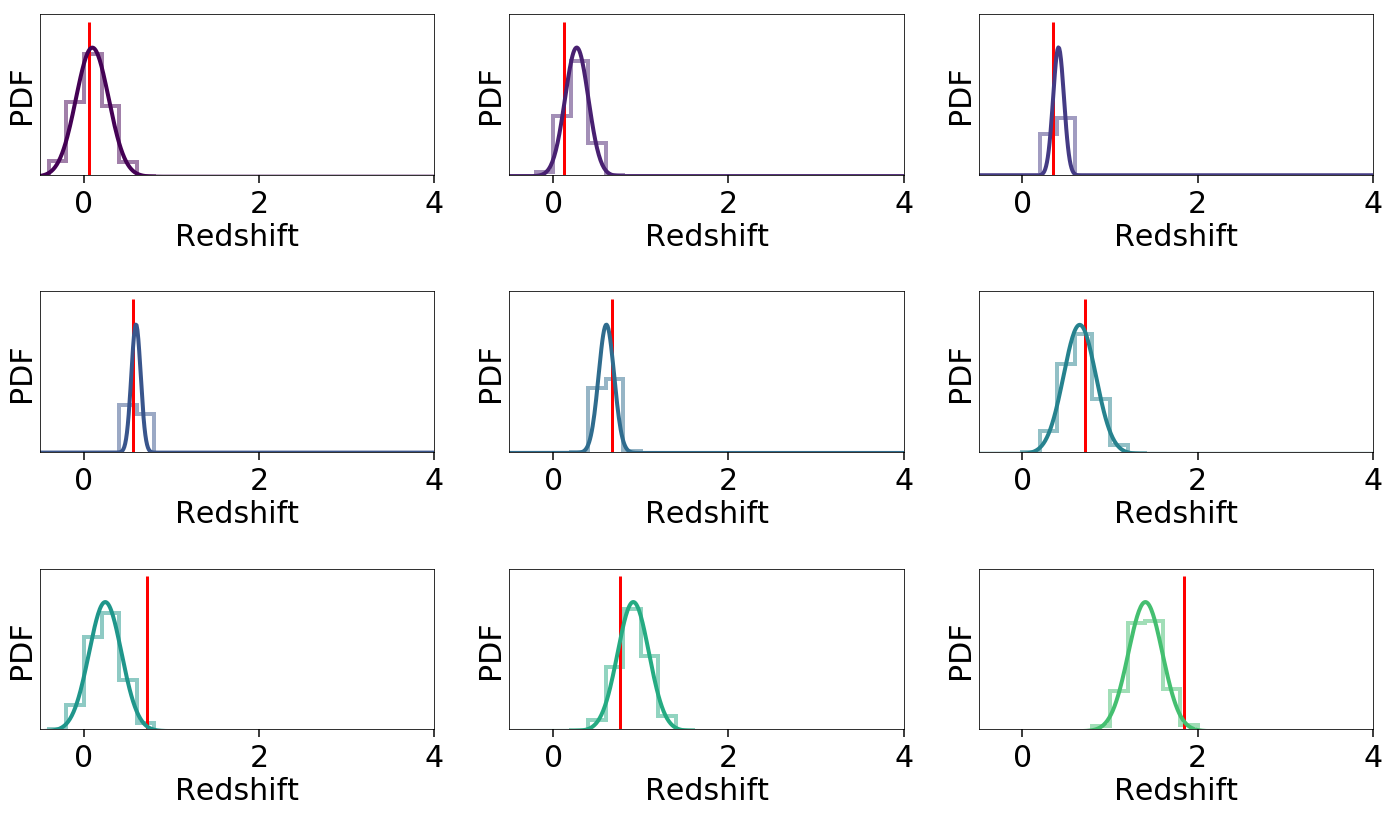

In [8]:
# plot some PDFs
plt.figure(figsize=(20, 12))
Nfigs = (3, 3)
Nplot = np.prod(Nfigs)
colors = plt.get_cmap('viridis')(np.linspace(0., 0.7, Nplot))
idxs = np.random.choice(Nobs, size=Nplot)
idxs = idxs[np.argsort(redshifts[idxs])]
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    plt.plot(zgrid, zpdf[j], color=c, lw=4)
    plt.hist(zbins_mid, zbins, weights=zpdf_bins[j], 
             color=c, lw=4, alpha=0.5, histtype='step')
    plt.vlines(redshifts[j], 0., max(zpdf[j] * 1.2), color='red', 
               lw=3)
    plt.xlim([-0.5, 4])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

We can verify that these are PDFs in a statistical sense by computing the empirical CDF and comparing our results to that expected from a uniform distribution, showcasing that indeed our likelihoods provide proper coverage (as constructed).

K-S Test p-value = 0.641


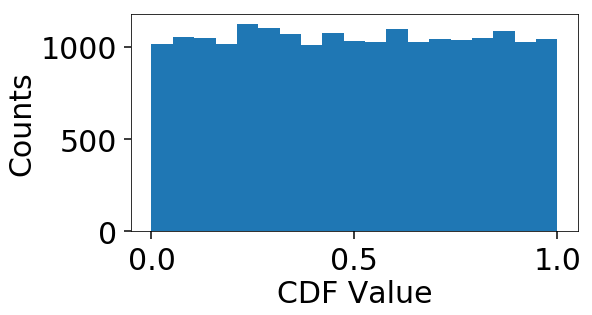

In [9]:
from scipy.stats import norm as normal
from scipy.stats import kstest

# compute CDF draws
cdf_vals = normal.cdf(redshifts, loc=mu, scale=sigma)
plt.figure(figsize=(8, 4))
plt.hist(cdf_vals, bins=np.linspace(0., 1., 20))
plt.xlabel('CDF Value')
plt.ylabel('Counts')

# compute KS test statistic
ks_result = kstest(rvs=cdf_vals, cdf='uniform')
print('K-S Test p-value = {:0.3f}'.format(ks_result[1]))

In [10]:
# generate Gaussian PDFs over grid
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

Our definition for the number density above

$$ N(h|\mathbf{g}) \equiv \sum_{g \in \mathbf{g}} P(h|g) = \sum_{g \in \mathbf{g}} \frac{P(g|h)P(h)}{\sum_{h \in \mathbf{h}} P(g|h)P(h)} $$

is now equivalent to stacking our posteriors. If we assume that our prior is uniform, this reduces to

$$ N(h|\mathbf{g}) = \sum_{g \in \mathbf{g}} P(g|h) $$

which is just effectively "stacking" our redshift PDFs shown above (either in the binned or unbinned cases).

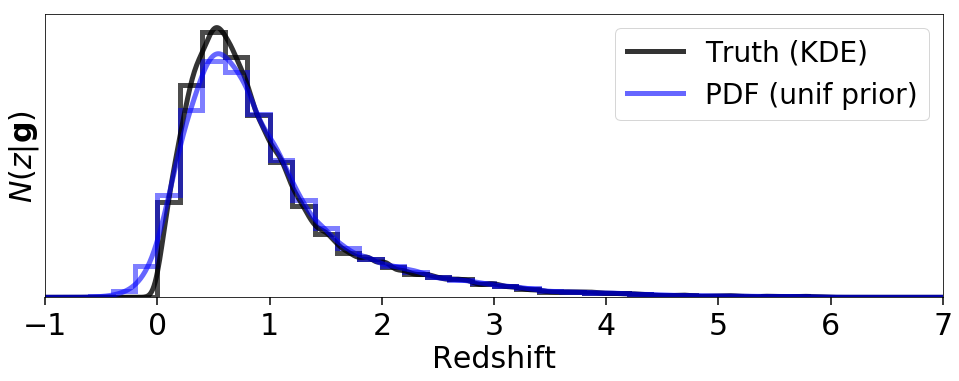

In [11]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, normed=True)
plt.hist(zbins_mid, bins=zbins, weights=zpdf_bins.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

Now that we're using PDFs instead of the true observed estimates, we can see this is not actually a fully accurate reconstruction of the true PDF -- our noise broadens the estimated population redshift distribution, especially around the peak redshift density.

# Population Modeling

We now want to derive *errors* around our $N(h|\mathbf{g})$ predictions from our underlying PDFs. In particular, we want to generate a series of $k$ samples 

$$ \mathbf{n}_{\mathbf{g}}^{(1)}, \dots, \mathbf{n}_{\mathbf{g}}^{(k)} | \boldsymbol{\Lambda}_{\mathbf{g}} \sim P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}}) $$ 

where $\mathbf{n}_{\mathbf{g}} = \lbrace \dots, n_h(\mathbf{g}), \dots \rbrace = \lbrace \dots, N(h|\mathbf{g}), \dots \rbrace$ are the observed (discrete) counts and $\boldsymbol{\Lambda}_{\mathbf{g}} = \sum_{g \in \mathbf{g}} \boldsymbol{\ell}_g$ are the (effective) mean counts with $\boldsymbol{\ell}_g = \lbrace \dots, P(h|g) \dots \rbrace$ the associated likelihood vector of galaxy $g$.

In [12]:
# number of samples
Nsamples = 500

In general, we can write 

$$ P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}}) = \int P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\phi}) P(\boldsymbol{\phi}|\boldsymbol{\Lambda}_{\mathbf{g}}) d\boldsymbol{\phi} $$

where $\boldsymbol{\phi}$ are **nuisance parameters** that we want to marginalize over. $P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}})$ , however, frequently does not have a closed form. Here, we will instead approximate it using the **maximum-likelihood (ML)** result $P(\boldsymbol{\phi}|\boldsymbol{\Lambda}_{\mathbf{g}}) \approx \delta\left(\boldsymbol{\phi} - \boldsymbol{\phi}_{\textrm{ML}}(\boldsymbol{\Lambda}_\mathbf{g})\right)$ such that

$$ P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}}) \approx P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\phi}_{\textrm{ML}}(\boldsymbol{\Lambda})) $$

## Poisson Approximation

A common approximation is that there are some number of galaxies $N_h$ within the $h$-th redshift bin, and we observe some random realization of this underlying count. The number of objects in each bin (assuming they're independent from each other) then follows a **Poisson distribution** where

$$ n_h|\lambda_h \sim \textrm{Pois}(\lambda = \lambda_h) $$

This treats $n_h(\mathbf{g})$ as a Poisson **random variable** (and $\mathbf{n}_{\mathbf{g}}$ as a Poisson **random vector**) that we want to simuate.

The ML solution for $\boldsymbol{\lambda}_{\mathbf{g}}(\hat{\mathbf{n}}_\mathbf{g})$ is

$$ \boldsymbol{\lambda}_{\mathbf{g},\textrm{ML}}(\hat{\mathbf{n}}_\mathbf{g}) = \boldsymbol{\Lambda}_{\mathbf{g}} $$

This gives us

$$ n_h|\Lambda_h \sim \textrm{Pois}(\lambda = \Lambda_h) $$

In [13]:
# draw Poisson samples
pdf1 = zpdf.sum(axis=0)  # stack PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # transform to counts
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in range(Nsamples)])  # draw samples

The Poisson approximation implies that the number of objects we observe at a given redshift is simply a counting process with mean $\boldsymbol{\mu} = \boldsymbol{\lambda}_{\mathbf{g}} = \hat{\mathbf{n}}_{\mathbf{g}}$. This isn't quite right, since this assumes the number of objects observed at different $z_h$'s are independent, when we know that there must be *some* covariance due to each object's redshift PDF. More importantly, however, this approximation implies that the total number of objects we observe doesn't remain constant!

Let's see how our results look.

In [14]:
def zplot(samples, label='type', color='blue', downsample=1):
    """Plot our draws."""
    
    [plt.plot(zgrid, samples[i], lw=2, color=color, alpha=0.07)
     for i in np.arange(Nsamples)[::downsample]]
    plt.plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black',
             alpha=0.7)
    plt.plot(zgrid, pdf * 0.0 - 1e4, lw=3, color=color,
             alpha=0.5, label=label)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(pdf / pdf.sum() * Nobs) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

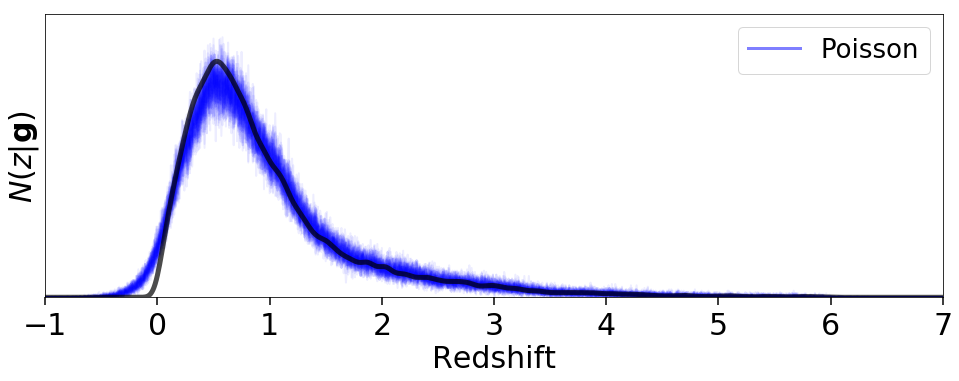

In [15]:
# plotting
plt.figure(figsize=(14, 6))
zplot(pdf1_samples, label='Poisson', color='blue', downsample=10)

## Multinomial Approximation

One improvement on the Poisson is to assume our observed counts $\mathbf{n}_\mathbf{g}$ for our observed set of $N_\mathbf{g}$ objects are drawn from the **Multinomial distribution** such that

$$ \mathbf{n}_{\mathbf{h}}|N_\mathbf{g},\mathbf{p}_\mathbf{g} \sim \textrm{Mult}\left(n = N_\mathbf{g}, \mathbf{p} = \mathbf{p}_{\mathbf{g}}\right) $$

The ML result is

$$ \mathbf{p}_{\mathbf{g},\textrm{ML}} = \boldsymbol{\Lambda}_\mathbf{g}/N_\mathbf{g} $$

Our number counts are then distributed as

$$
\mathbf{n}_{\mathbf{g}}|N_\mathbf{g},\boldsymbol{\Lambda}_\mathbf{g} \sim \textrm{Mult}\left(n = N_\mathbf{g}, \mathbf{p} = \boldsymbol{\Lambda}_\mathbf{g}/N_\mathbf{g}\right)
$$

In [16]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

The Multinomial approximation implies that the redshift PDF of a random observed galaxy $g$ is proportional to the population PDF. In other words, a given galaxy is just a random draw from the population. The Multinomial has the benefit of keeping the overall number of galaxies $N_\mathbf{g}$ constant, and in doing so induces *negative* correlations among the individual categories (redshifts). However, this approximation ignores measurement errors (i.e. individual galaxy PDFs), which can induce additional correlations among redshifts.

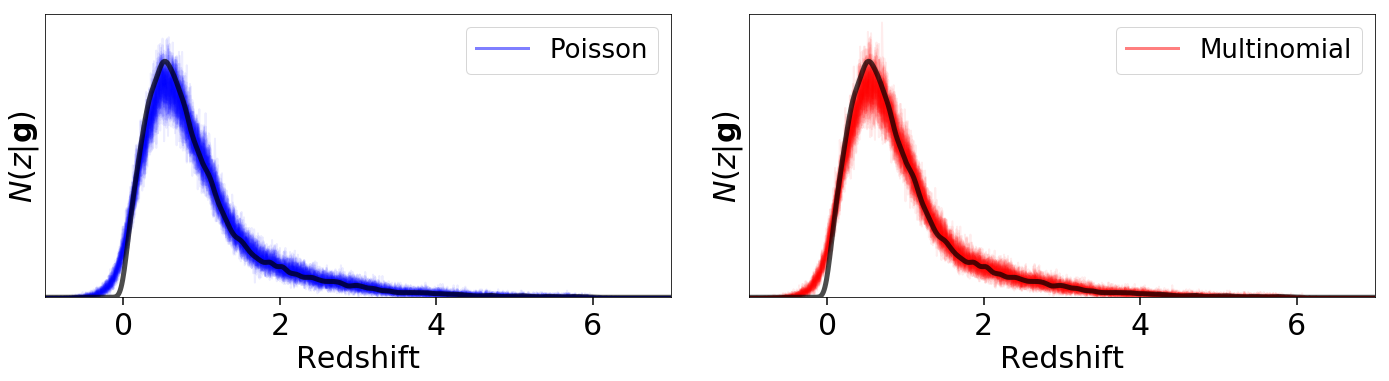

In [17]:
# plotting
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue', downsample=10)
plt.subplot(1, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red', downsample=10)

## Posterior Samples

Any particular galaxy $g$ with PDF $\mathbf{p}_g$ is actually located at a particular redshift $z_g$, with the corresponding redshift PDF modeling our uncertainty over its true redshift. Given the posterior vector 

$$ \mathbf{p}_g = \frac{\boldsymbol{\ell}_g \odot \boldsymbol{\pi}_\mathbf{g}}{\sum_{h \in \mathbf{h}} \ell_g(h) \cdot \pi_\mathbf{g}(h)} $$

where $\boldsymbol{\ell}_g$ is the likelihood vector, $\boldsymbol{\pi}_\mathbf{g}$ is the prior vector, and $\odot$ is the **Hadamard product** (i.e. element-wise multiplication), the distribution of $z_g$ ($\mathbf{n}_g$) can be modeled as a Categorial (Multinomial) random variable such that

$$
z_g|\mathbf{p}_g \sim \textrm{Cat}\left(\mathbf{p}=\mathbf{p}_g\right)
\quad \Leftrightarrow \quad 
\mathbf{n}_g|\mathbf{p}_g \sim \textrm{Mult}\left(n=1, \mathbf{p}=\mathbf{p}_g\right)
$$

where $\mathbf{n}_g$ is $1$ at $z_g$ and zero elsewhere. 

Assuming as before that our prior $\boldsymbol{\pi}_\mathbf{g} = \mathbf{1}$, the redshift number density is then

$$
\mathbf{n}_\mathbf{g}|\lbrace\boldsymbol{\ell}_g\rbrace = \sum_{g \in \mathbf{g}} \mathbf{n}_g|\boldsymbol{\ell}_g
$$

This represents a convolution of a series of Multinomial-distributed random variables with different PDFs. Since $\boldsymbol{\Lambda}_\mathbf{g} = \sum_{g \in \mathbf{g}} \boldsymbol{\ell}_g$, this implicitly includes the population distribution through each of the individual objects.

While this doesn't have a simple closed-form solution, it is straightforward to draw samples $\mathbf{n}_{\mathbf{g}}^{(i)}$ from this distribution by drawing redshifts from each galaxy's PDF and then stacking the results. This procedure intuitively makes sense: we simulate our uncertainties on $\mathbf{n}_\mathbf{g}$ by simulating our uncertainties on the individual redshifts from $\boldsymbol{\ell}_g$.

In [18]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
zpdf_norm = zpdf / zpdf.sum(axis=1)[:, None]
for j in range(Nsamples):
    if j % 50 == 0:
        sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf_norm[i])

 0 50 100 150 200 250 300 350 400 450

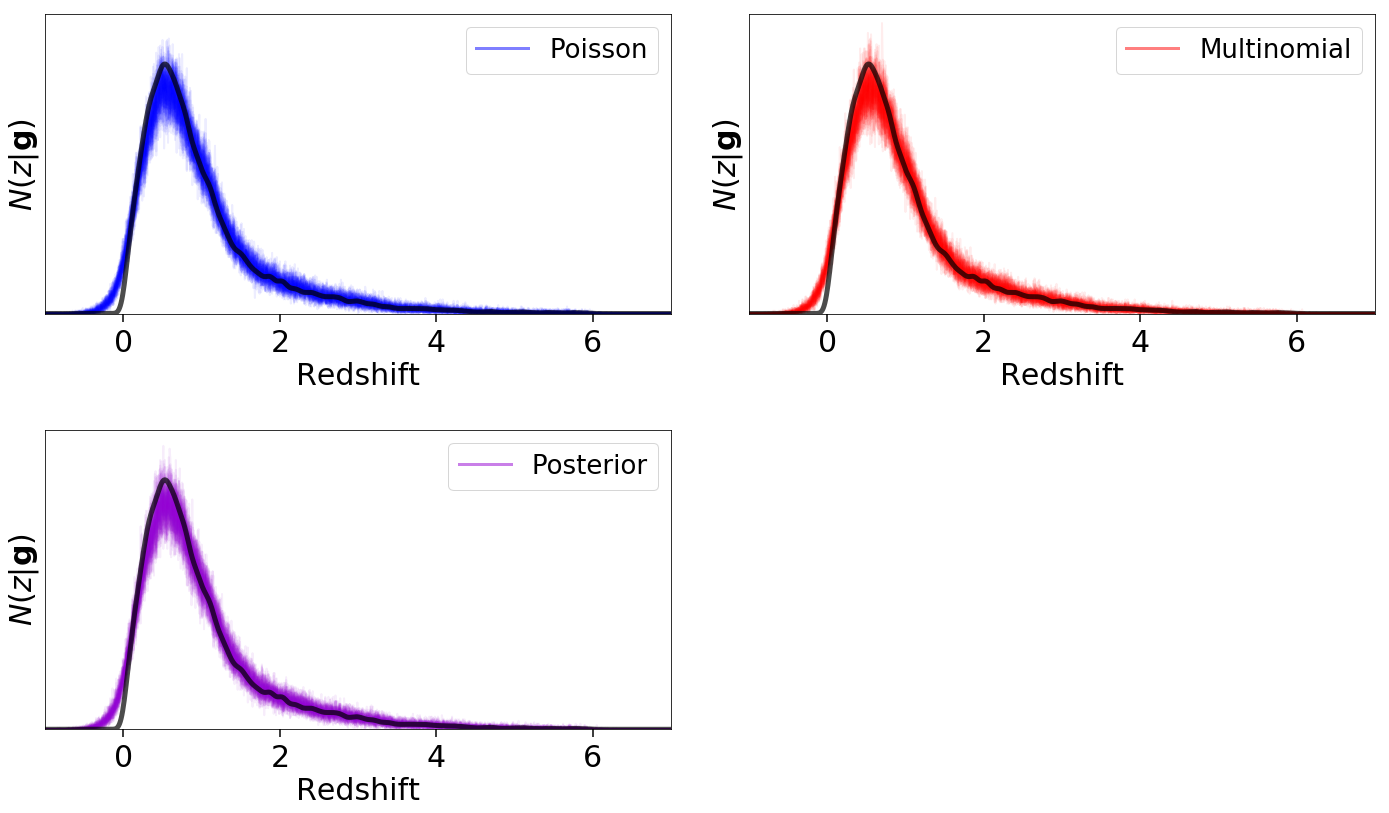

In [19]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue', downsample=10)
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red', downsample=10)
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet', downsample=10)

Let's also check out how our results look at lower (binned) resolution.

In [20]:
def zplot_bin(samples, label='type', color='blue', binning=5, downsample=1):
    """Plot our binned draws."""
    [plt.hist(zgrid + 1e-5, zgrid[::binning], 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.15) 
     for i in np.arange(Nsamples)[::downsample]]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zgrid[::binning], 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

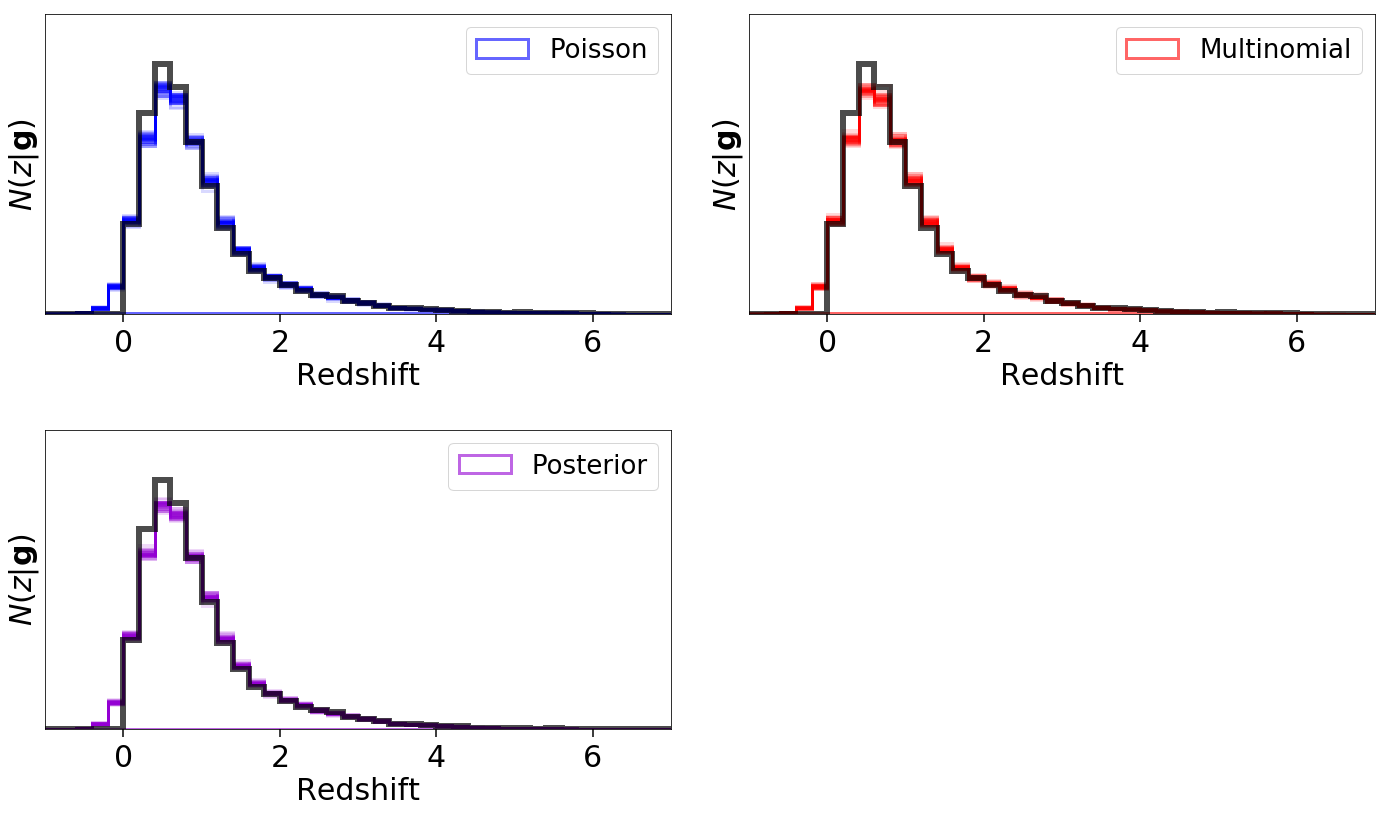

In [21]:
# plotting binned results
dbin = int(round(dzbin / dzgrid))
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=dbin, downsample=10)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=dbin, downsample=10)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=dbin, downsample=10)

Finally, let's check out the covariances among the draws for redshift snapshot.

In [22]:
def cov_draws(samples, bin1=(60, 80), bin2=(80, 100), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zgrid)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=8, alpha=0.6)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin1[0]], 
                                                           zgrid[bin1[1]]))
    plt.ylabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin2[0]], 
                                                           zgrid[bin2[1]]))
    plt.legend(fontsize=28, loc=1)
    plt.tight_layout()

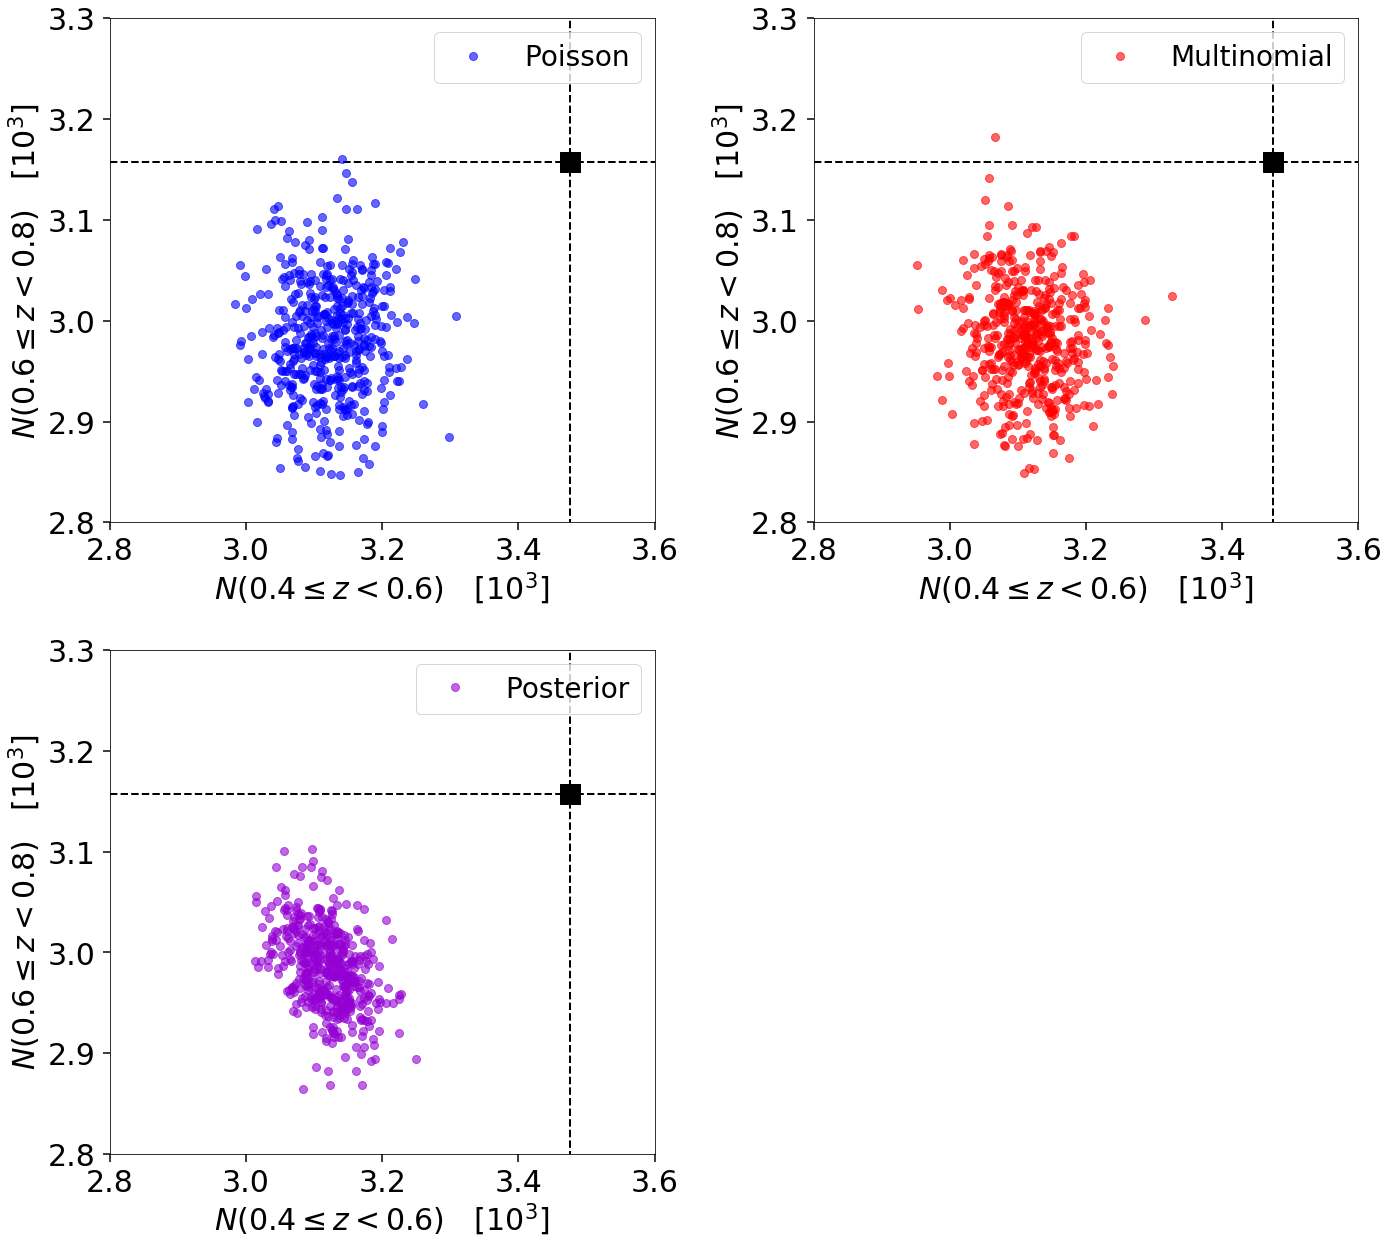

In [23]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(pdf1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(pdf2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(pdf3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='darkviolet', label='Posterior')

Even in this ideal case, our results appear to be slightly off from the true value. In addition, while the posterior results appear to capture the correct covariance structure, they also severely underestimate the uncertainties. To properly derive the distribution of the population, we need to model the population and individual objects jointly using hierarchical models.

# Hierarchical Modeling

So far, our results have been computed assuming $\boldsymbol{\pi}_\mathbf{g}=\mathbf{1}$ such that our posteriors $\mathbf{p}_g=\boldsymbol{\ell}_g$. Not all our bins are equally likely, however: the population distribution appears quite far from uniform, and we know (*a priori*) that redshifts cannot be negative. Rather than probing the conditional distribution $P(\mathbf{n}_\mathbf{g}|\boldsymbol{\pi}_\mathbf{g}, \boldsymbol{\phi})$, we are thus interested in probing the **joint distribution** of $P(\mathbf{n}_\mathbf{g}, \boldsymbol{\pi}_\mathbf{g}|\boldsymbol{\phi})$ using **hierarchical modeling** conditioned on some set of **hyperparameters** $\boldsymbol{\phi}$ and **hyperpriors** $P(\boldsymbol{\pi}_\mathbf{g}|\boldsymbol{\phi})$.

## Hyperpriors

A "natural" prior for the Categorical/Multinomial is the **Dirichlet distribution** $\textrm{Dir}(\boldsymbol{\alpha})$ with concentration vector $\boldsymbol{\alpha}$, which is the **conjugate prior** to the Categorical/Multinomial. Under this Dirichlet hyperprior, our new model becomes

$$ \boldsymbol{\pi}_\mathbf{g}|\boldsymbol{\alpha} \sim N_\mathbf{g} \times \textrm{Dir}(\boldsymbol{\alpha}) $$

$$
\mathbf{n}_\mathbf{g}|\lbrace\boldsymbol{\ell}_g\rbrace,\boldsymbol{\pi}_\mathbf{g} = \mathbf{n}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace = \sum_{g \in \mathbf{g}} \mathbf{n}_g|\mathbf{p}_g, 
\quad
\mathbf{n}_g|\mathbf{p}_g \sim \textrm{Mult}\left(n=1, \mathbf{p}=\mathbf{p}_g\right)
$$

$\boldsymbol{\alpha}$ here functions as a set of **pseudo-counts** for each category, while the Dirichlet imposes similar structure on the prior as the Multinomial. Here we will take $\alpha_h(z_h)=1$ for $z_h \geq 0$ and $\alpha_h = 0.01$ for $z_h < 0$.

In [24]:
# initialize concentration parameters
alpha = np.ones(Ngrid)
alpha[zgrid < 0.] = 1e-2

## Sampling

How do we sample from such the joint distribution $P(\mathbf{n}_\mathbf{g}, \boldsymbol{\pi}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\alpha})$ using, e.g., **Markov Chain Monte Carlo (MCMC)**? The joint distribution does not exist in analytic form, and given that we are trying to sample $2 \times N_h$ parameters, it is intractable for typical **rejection samplers** that try and probe the joint distribution directly using, e.g., **Metropolis proposals**.

It is, however, particularly amenable to **Gibbs sampling**, which allows us to sample from joint distribution by iteratively sampling from the associated conditional distributions:

\begin{align}
\mathbf{n}_g^{(i)}|\boldsymbol{\ell}_g,\boldsymbol{\pi}_\mathbf{g}^{(i-1)} &\sim \textrm{Mult}\left(n=1, \mathbf{p}=\mathbf{p}_g^{(i-1)}\right) \\
\mathbf{n}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g^{(i-1)}\rbrace &=  \sum_{g \in \mathbf{g}} \mathbf{n}_g^{(i)}|\mathbf{p}_g^{(i-1)}, \\
\boldsymbol{\pi}_\mathbf{g}^{(i)}|\mathbf{n}_\mathbf{g}^{(i)},\boldsymbol{\alpha} &\sim N_\mathbf{g} \times \textrm{Dir}(\mathbf{n}_\mathbf{g}^{(i)} + \boldsymbol{\alpha})
\end{align}

This gives us a straightforward scheme for sampling:
1. Sample individual redshifts from their new PDFs using the prior weights $\boldsymbol{\pi}_\mathbf{g}^{(i-1)}$ sampled from the previous iteration.
2. Add up the total number of counts to derive $\mathbf{n}_\mathbf{g}^{(i)}$.
3. Sample the prior weights using the current number of counts $\mathbf{n}_\mathbf{g}^{(i)}$.

In [25]:
def mcmc_gibbs(pdfs, Nsamples, Ngrid, 
               pos_init=None, alpha=None,
               T=None, Nburn=0, Nthin=1, 
               verbose=True, Nprint=1):
    """Using MCMC with Gibbs sampling to sample from
    the joint distribution of our hierarchical model.
    Uses a specified temperature schedule to assist with
    burn-in using simulated annealing/tempering."""
    
    Ntot = Nthin * (Nsamples + Nburn)
    Nobs = len(pdfs)
    samples_pi = np.zeros((Nsamples, Ngrid))
    samples_n = np.zeros((Nsamples, Ngrid), dtype='int')
    if T is None:
        T = np.ones(Ntot)
    if pos_init is None:
        pos_init = np.ones_like(Ngrid)

    prior = pos_init  # alpha prior
    cprint = 1
    for j in range(Ntot):
        count = int(j / Nthin) - Nburn
        if verbose and (j + 1) % Nthin == 0 and cprint == Nprint: 
            sys.stderr.write('{0} '.format(count + 1))
            cprint = 1
        else:
            cprint += 1

        # Compute new posterior.
        nstack = np.zeros(Ngrid)
        pdf_t = pdfs * prior
        pdf_t /= pdf_t.sum(axis=1)[:, None]

        # Stack posterior.
        for i in range(Nobs):
            nstack += np.random.multinomial(1, pdf_t[i])

        # Sample population weights.
        prior = np.random.dirichlet(nstack / T[j] + alpha) * Nobs + 1e-5

        # Save samples.
        if (j + 1) % Nthin == 0 and count >= 0:
            samples_n[count] = nstack.copy()
            samples_pi[count] = prior.copy()
            
    return samples_n, samples_pi

In [26]:
# sample from our hierarchical model
Ndraws = 2500
T = np.append(np.linspace(30., 1., 500), np.ones(Ndraws - 500))
pdf4_samples_n, pdf4_samples_pi = mcmc_gibbs(zpdf, Ndraws, Ngrid, T=T, 
                                             pos_init=alpha, alpha=alpha,
                                             Nprint=10)

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 222

As with any MCMC sampler, we need time to "burn in" to the stationary distribution and often some subsequent thinning of the to ensure (relatively more) independent samples. We check both of these conditions below by looking at the autocorrelation time for a few of our redshift grid points and the general autocorrelation for $\Delta t=1$.

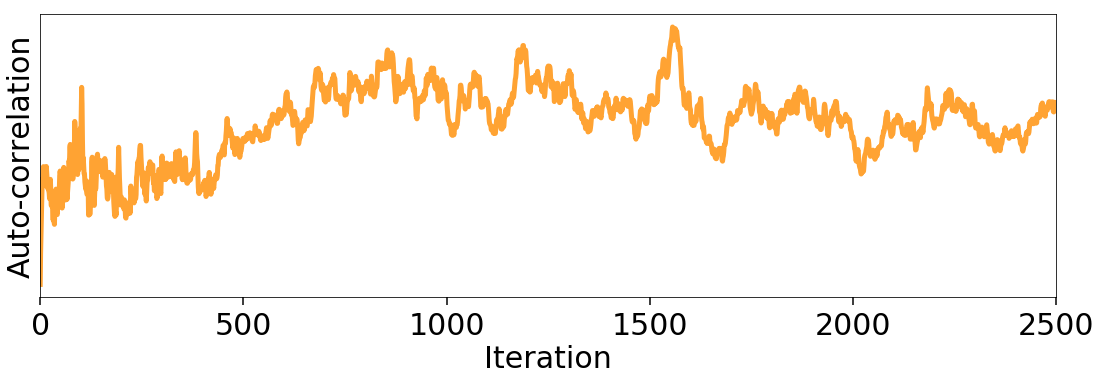

In [27]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(pdf4_samples_n[i], pdf4_samples_n[i+1])
                     for i in range(Ndraws - 1)]).flatten()
plt.plot(autocorr, lw=5, color='darkorange', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., Ndraws - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

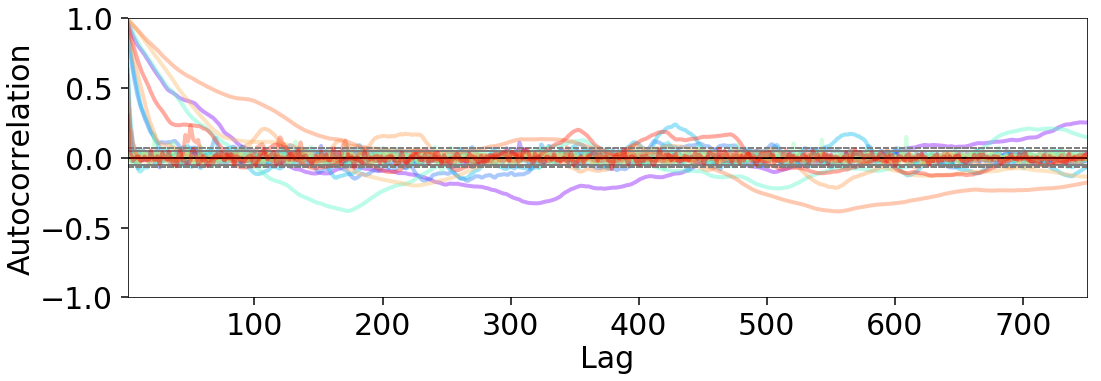

In [28]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 1000
Nplot = 20
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
ids = np.random.choice(Ngrid, size=Nplot, replace=False)
[autocorrelation_plot(pdf4_samples_pi[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(ids, colors)]
plt.xlim([1, (Ndraws - Nburnin) / 2])
plt.tight_layout()

While most of the vector elements of $\boldsymbol{\pi}_\mathbf{g}$ have small autocorrelation times, a few have ones that are pretty large, which is good to keep in mind.

In [29]:
# remove burn-in samples and thin our results
Nthin = 3
hpdf_samples_n = pdf4_samples_n[Nburnin::Nthin]
hpdf_samples_pi = pdf4_samples_pi[Nburnin::Nthin]

## Results

Now let's see how we did!

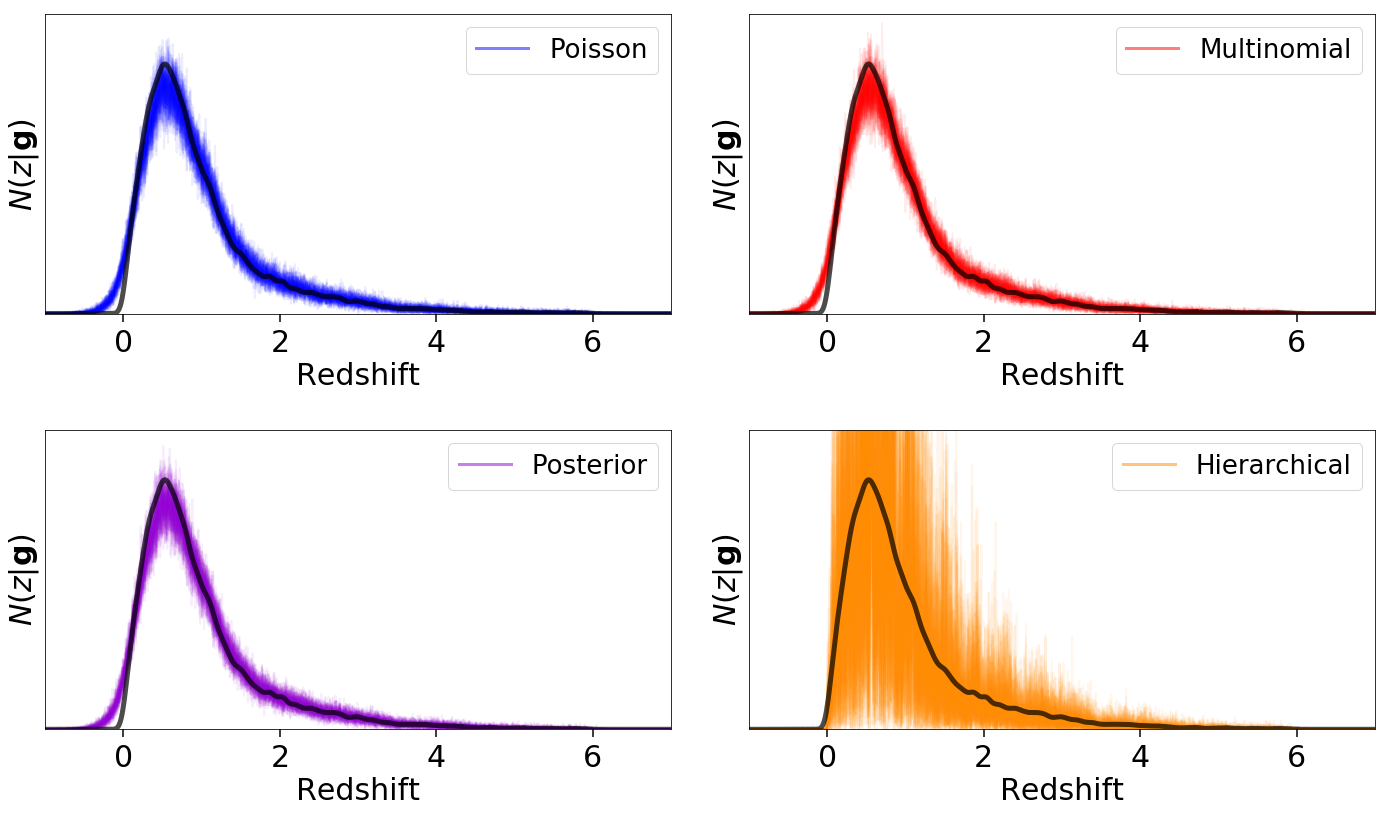

In [30]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue', downsample=10)
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red', downsample=10)
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet', downsample=10)
plt.subplot(2, 2, 4)
zplot(hpdf_samples_n, label='Hierarchical', color='darkorange', downsample=10)

Our hierarchical sample appears to experience some enourmous variation! There are a few primary reasons for this. Most crucially, our Dirichlet distribution is fundamentally an *unordered* distribution over our grid. By disregarding the fact that the amplitude of nearby redshift bins should inherently be strongly correlated with each other, it allows for more (unphysical) variation than might otherwise be possible. 

Another reason is that our PDFs are relatively broad compared to the resolution of our redshift grid ($\sigma_z \approx 0.05$ compared with $\Delta z = 0.01$), especially given the size of our sample (20k galaxies). This lends itself to a lot of possible sample variation since the total "number" of galaxies occupying a given redshift value can end up fluctuating to be (relatively) low.

It is important to note that we can't just reduce the number of elements (kernels) in our basis set to improve our constraints: to properly model the redshift distribution, we *need* to use a set of kernels expansive/flexible enough to compute an accurate approximation to the prior. While this might impact our sampling efficiency, in general these noisy results can still can be leveraged to give good predictions at coarser resolutions, as shown below.

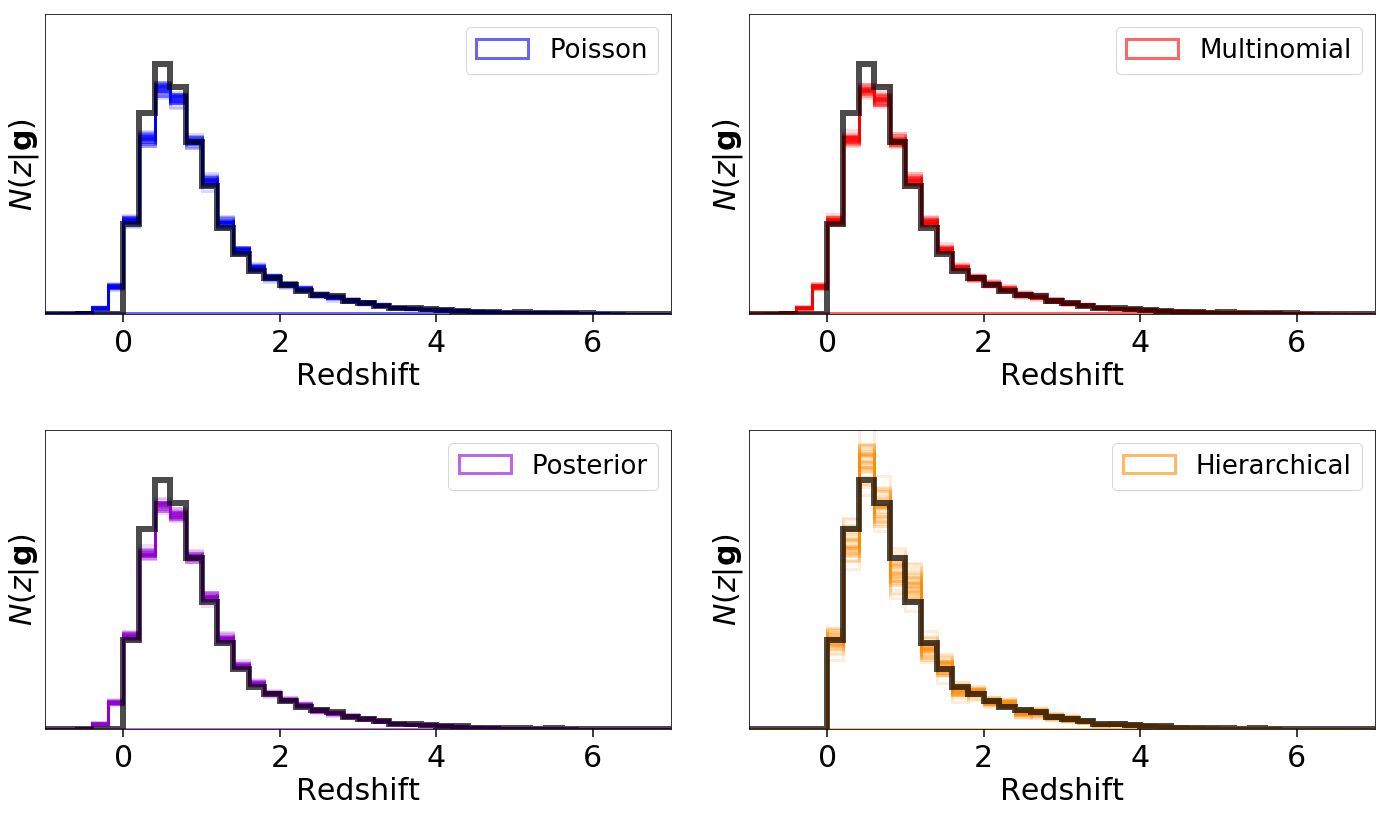

In [31]:
# plotting binned results
dbin = int(round(dzbin / dzgrid))
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue',
          binning=dbin, downsample=10)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red',
          binning=dbin, downsample=10)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet',
          binning=dbin, downsample=10)
plt.subplot(2, 2, 4)
zplot_bin(hpdf_samples_n, label='Hierarchical', color='darkorange',
          binning=dbin, downsample=10)

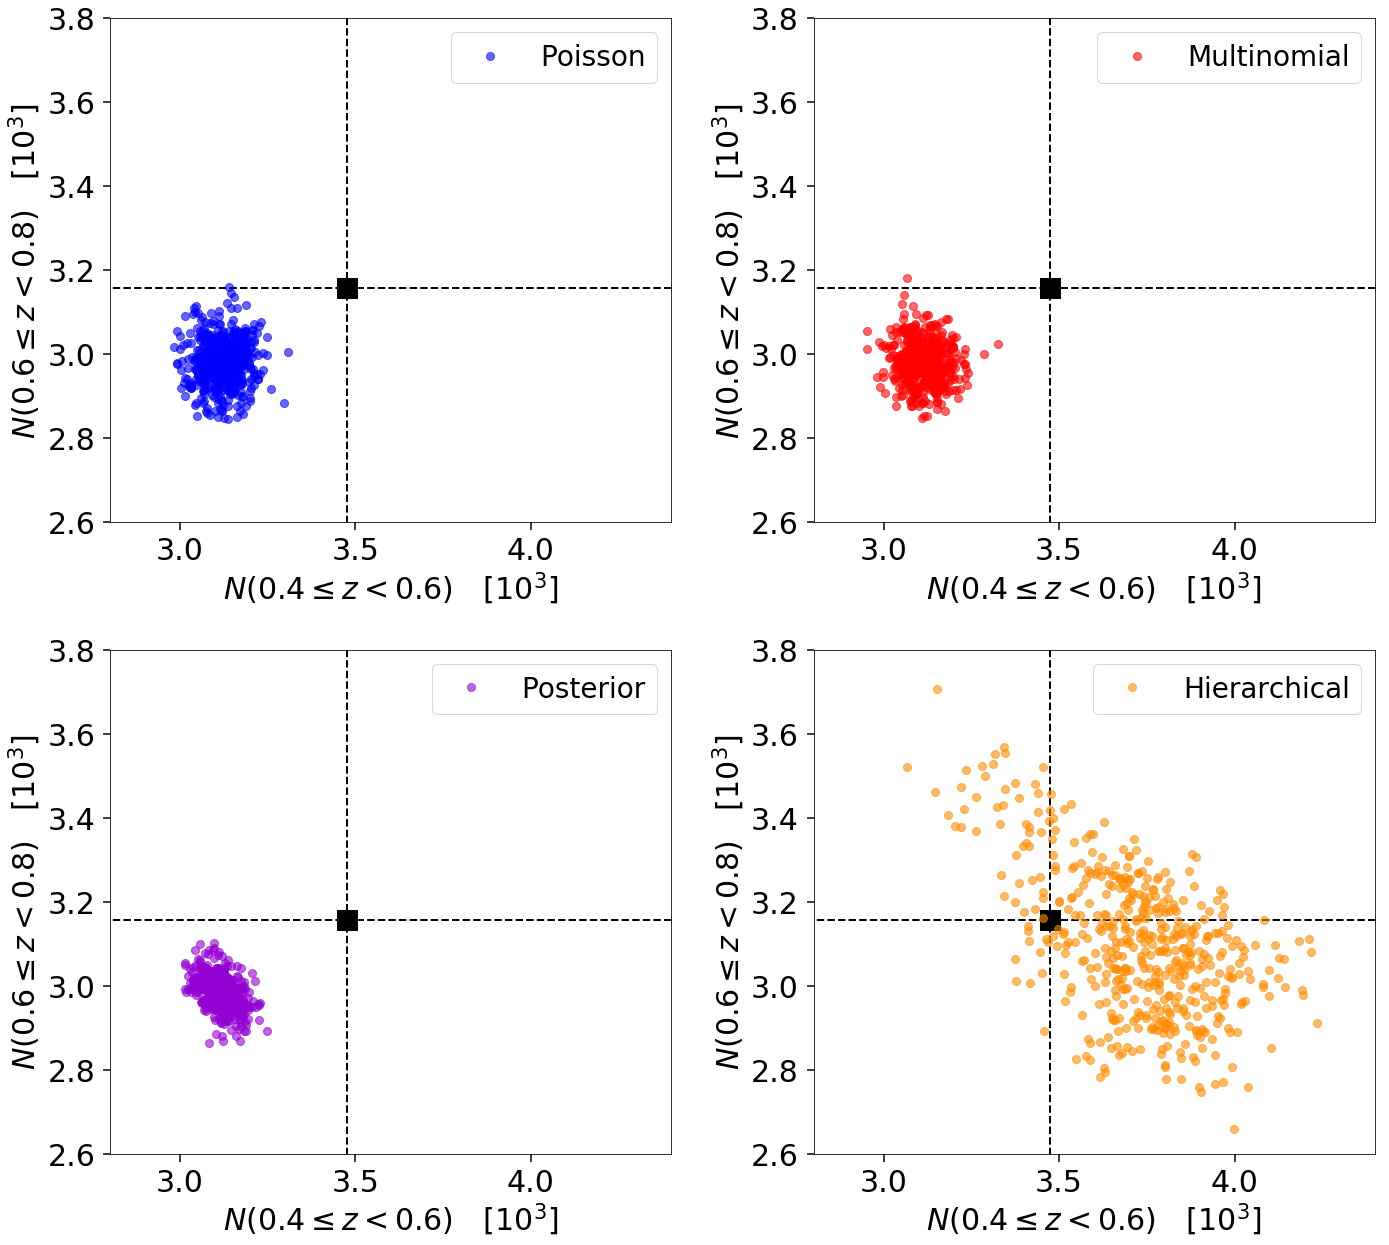

In [32]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(pdf1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.4), ylim=(2.6, 3.8),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(pdf2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.4), ylim=(2.6, 3.8),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(pdf3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.4), ylim=(2.6, 3.8),
          color='darkviolet', label='Posterior')
plt.subplot(2,2,4)
cov_draws(hpdf_samples_n, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.4), ylim=(2.6, 3.8),
          color='darkorange', label='Hierarchical')

Only our hierarchical model is able to properly recover the true underlying distribution while maintaining the associated structure.

## Hierarchical Shrinkage

Finally, let's take a look at our new PDFs, marginalizing over the prior weights. This should shrink/shift our associated PDFs based on our marginalized population estimates, improving our individual results.

In [33]:
# construct PDFs marginalized over the prior weights
zpdf_new = np.zeros_like(zpdf)
for j, prior in enumerate(hpdf_samples_pi):
    if j % 10 == 0:
        sys.stderr.write(' {0}'.format(j))
    zpdf_t = zpdf * prior
    zpdf_t /= np.trapz(zpdf_t, zgrid)[:, None]
    zpdf_new += zpdf_t / Nsamples

 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490

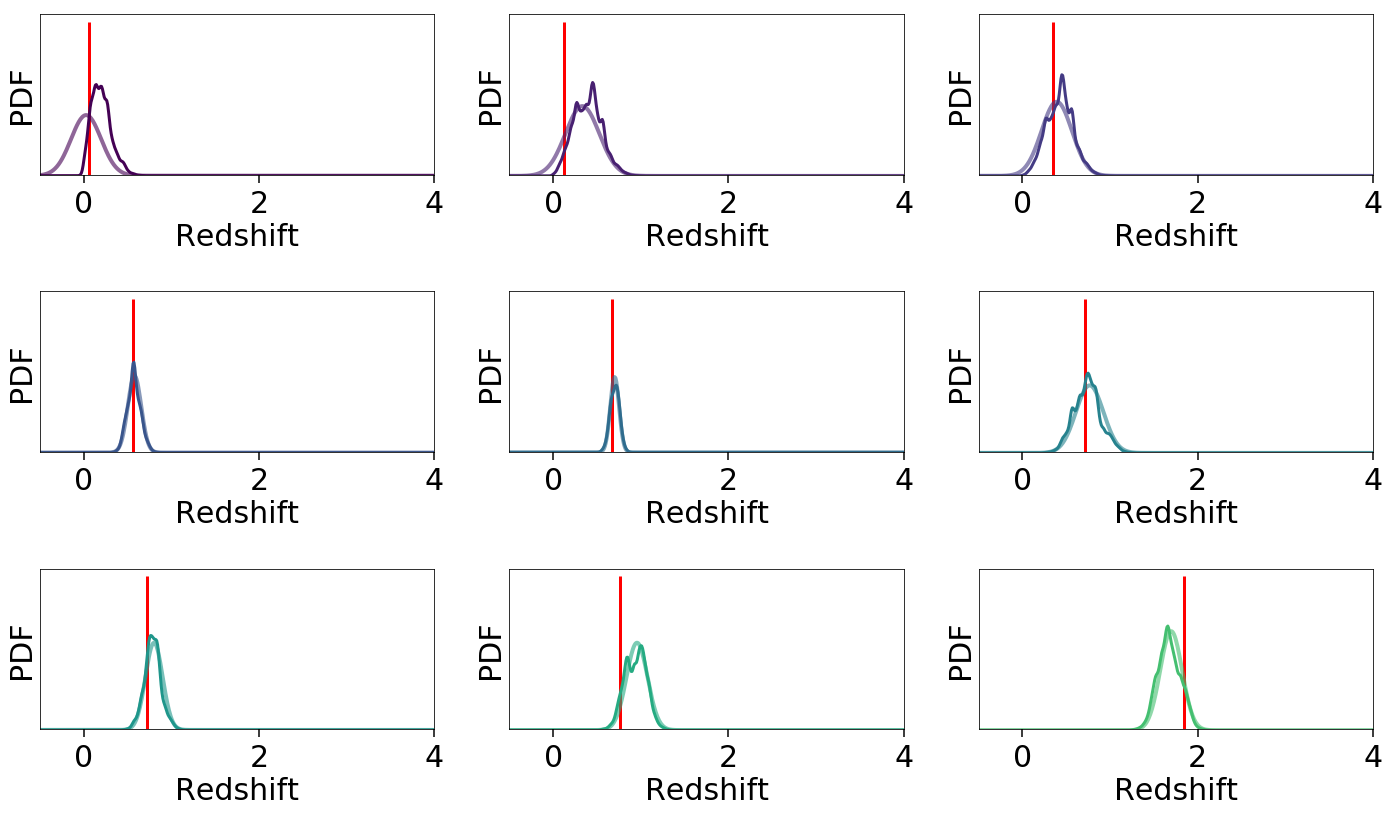

In [34]:
# plot some (slightly smoothed) PDFs
plt.figure(figsize=(20, 12))
Nfigs = (3, 3)
Nplot = np.prod(Nfigs)
colors = plt.get_cmap('viridis')(np.linspace(0., 0.7, Nplot))
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    plt.plot(zgrid, zpdf[j], color=c, lw=4, alpha=0.6)
    pt = frankenz.pdf.gauss_kde(zgrid, np.ones_like(zgrid) * 0.02, 
                                zgrid, y_wt=zpdf_new[j])
    plt.plot(zgrid, pt, color=c, lw=3)
    plt.vlines(redshifts[j], 0., 
               max(max(zpdf_new[j]), max(zpdf[j])) * 1.2,
               color='red', lw=3)
    plt.xlim([-0.5, 4])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

Finally, we can check whether this new set of samples is consistent with being "statistical" PDFs using the same CDF-style test as with our original likelihoods. To account for small errors introduced by numerical approximation of the CDF using a set of grid points, we use a 2-sample KS test to compare the results to the same procedure computed using our original set of PDFs.

In [35]:
# compute CDF draws from old/new posteriors
cdf_vals = np.array([np.interp(redshifts[i], zgrid, 
                               np.cumsum(zpdf[i]) / 
                               np.sum(zpdf[i]), 
                               left=0., right=1.)
                     for i in range(Nobs)])
hcdf_vals = np.array([np.interp(redshifts[i], zgrid, 
                                np.cumsum(zpdf_new[i]) / 
                                np.sum(zpdf_new[i]), 
                                left=0., right=1.)
                     for i in range(Nobs)])

# evaluate 2-sample KS test
from scipy.stats import ks_2samp

# compute KS 2-sample test statistic
ks_result = ks_2samp(cdf_vals, hcdf_vals)
print('K-S Test (2-sample) p-value = {:0.3f}'.format(ks_result[1]))

K-S Test (2-sample) p-value = 0.932


Our new population-marginalized PDFs thus appear to have full coverage of individual redshifts, identical to our original set of likelihoods.